<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-train-и-valid-выборки" data-toc-modified-id="Разделение-данных-на-train-и-valid-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение данных на train и valid выборки</a></span></li><li><span><a href="#Масштабирование-численных-признаков" data-toc-modified-id="Масштабирование-численных-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Масштабирование численных признаков</a></span></li><li><span><a href="#Обучение-модели-и-получение-предсказаний-на-валидационной-выборке" data-toc-modified-id="Обучение-модели-и-получение-предсказаний-на-валидационной-выборке-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение модели и получение предсказаний на валидационной выборке</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Функция-для-расчёта-прибыли" data-toc-modified-id="Функция-для-расчёта-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Функция для расчёта прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков-для-каждого-региона" data-toc-modified-id="Расчёт-прибыли-и-рисков-для-каждого-региона-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков для каждого региона</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выбор локации для скважины

Добывающей компании нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

*Шаги для выбора локации*:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 

    geo_data_0.csv.
    geo_data_1.csv.
    geo_data_2.csv.


*Признаки*:
- *id* — уникальный идентификатор скважины;
- *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы);

*Таргет*:
- *product* — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

Для начала импортнем нужные нам библиотеки

In [2]:
# импорты из стандартной библиотеки
import warnings
import re

# импорты сторонних библиотек
import pandas as pd
import numpy as np

# импорты модулей текущего проекта
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

Считаем данные для трех регионов с помощью `read_csv`

In [3]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Обзор данных

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Формат датасетов для трех регионов идентичен

In [7]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропущенных значений в датасетах нет, с типом данных проблем нет

In [8]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**`Промежуточный вывод`:**

    - имеем три датафрейма для трех разных регионов
    - все три датафрейма идентичны по количеству объектов
    - в них также идентичны и параменты этих объектов
    - пропусков в датафреймах нет
    - числовые параметры [f0, f1, f2] должны быть масштабированы
    - помимо необходимости масштабирования числовых параметров критических замечаний к датафреймам не заметил

## Обучение и проверка модели

### Разделение данных на train и valid выборки

Разделим данные на train и valid выборки.

Столбец id нам не понадобится для предсказания таргета, *удалим его*.

In [9]:
# X_0 - признаки, y_0 - таргет, 0 - обозначает первый регион
X_0 = geo_data_0.drop(['id', 'product'], axis=1)
y_0 = geo_data_0['product']

In [10]:
# делим на train и valid выборки
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0, y_0, test_size=0.25, random_state=RANDOM_STATE
)

Сделаем также и для остальных двух регионов

In [11]:
# регион 2
X_1 = geo_data_1.drop(['id', 'product'], axis=1)
y_1 = geo_data_1['product']

In [12]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1, y_1, test_size=0.25, random_state=RANDOM_STATE
)

In [13]:
# регион 3
X_2 = geo_data_2.drop(['id', 'product'], axis=1)
y_2 = geo_data_2['product']

In [14]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2, y_2, test_size=0.25, random_state=RANDOM_STATE
)

Данные всех регионов разделены на train и valid выборки, самое время приступить к масштабированию численных признаков, а затем и к обучению модели и получению предсказаний

### Масштабирование численных признаков

После того, как мы провели сплит на train и valid выборки, проведем масштабирование признаков f0, f1, f2 с помощью `StandardScaler`.

In [15]:
# эти признаки будем масштабировать
num_features = ['f0', 'f1', 'f2']

In [16]:
X_valid_0.describe()

,f0,f1,f2
count,25000.000000,25000.000000,25000.000000
mean,0.509356,0.250381,2.492837
std,0.871812,0.505131,3.243980
min,-1.302227,-0.807215,-12.088328
25%,-0.064883,-0.202686,0.256892
50%,0.510247,0.251546,2.505296
75%,1.084742,0.701453,4.686501
max,2.299810,1.331253,15.014250


In [17]:
%%capture --no-stdout


# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках train выборки, трансформируем ее же
X_train_0[num_features] = scaler.fit_transform(X_train_0[num_features])

# трансформируем и остальные выборки
X_valid_0[num_features] = scaler.transform(X_valid_0[num_features])
X_train_1[num_features] = scaler.transform(X_train_1[num_features])
X_valid_1[num_features] = scaler.transform(X_valid_1[num_features])
X_train_2[num_features] = scaler.transform(X_train_2[num_features])
X_valid_2[num_features] = scaler.transform(X_valid_2[num_features])

In [18]:
# смотрим на результат
X_valid_0.describe()

,f0,f1,f2
count,25000.000000,25000.000000,25000.000000
mean,0.013667,0.000629,-0.004025
std,0.999992,1.001848,0.998251
min,-2.064269,-2.096946,-4.491004
25%,-0.645001,-0.897958,-0.692080
50%,0.014689,0.002940,-0.000191
75%,0.673651,0.895259,0.671019
max,2.067368,2.144367,3.849118


Все получилось! Приступим к обучению модели и получению предсказаний

### Обучение модели и получение предсказаний на валидационной выборке

Объявим функцию `lr_function` которая поможет нам быстро обучить LR модель для трех регионов и на выходе даст нам значения среднего запаса предсказанного сырья и RMSE.

In [19]:
def lr_function(X_train, X_valid, y_train, y_valid, region):
    # создаем LR модель
    model = LinearRegression()
    
    # обучаем LR на трейн выборке и сразу предиктим на валидационной
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # сохраняем средний запас предсказанного сырья и RMSE в отдельные переменные
    y_pred_mean = y_pred.mean()
    rmse = mean_squared_error(y_valid, y_pred) ** 0.5
    
    # выводим на экран нужную информацию
    print(f'Регион {region}:')
    print('-----------------------------------------')
    print(f'Средний запас предсказанного сырья = {y_pred_mean:.3}')
    print(f'RMSE = {rmse:.4}')
    
    # возвращаем нужные показатели для того чтобы была возможность их себе сохранить
    return y_pred, rmse

In [20]:
y_pred_0, rmse_0 = lr_function(X_train_0, X_valid_0, y_train_0, y_valid_0, 1)

Регион 1:
-----------------------------------------
Средний запас предсказанного сырья = 92.6
RMSE = 37.58


In [21]:
y_pred_1, rmse_1 = lr_function(X_train_1, X_valid_1, y_train_1, y_valid_1, 2)

Регион 2:
-----------------------------------------
Средний запас предсказанного сырья = 68.7
RMSE = 0.8931


In [22]:
y_pred_2, rmse_2 = lr_function(X_train_2, X_valid_2, y_train_2, y_valid_2, 3)

Регион 3:
-----------------------------------------
Средний запас предсказанного сырья = 95.0
RMSE = 40.03


**`Промежуточный вывод:`**

Видим, что линейная регрессия хорошо справилась с предсказаниями для 2го региона (RMSE = 0.893), а с 1м и 3м регионом справилась похуже... (RMSE = 37.58 и RMSE = 40.03 соответственно)

## Подготовка к расчёту прибыли

Сначала нужно составить формулу прибыли, затем вместо прибыли подставить 0, что будет говорить о безубыточности и дальше уже  с помощью математических перестановок вывести чему будет равняться объем сырья.

In [23]:
# все ключевые значения для расчётов сохраним в отдельных переменных
COST_PRICE = 10_000_000_000
UNIT_OF_PRODUCT_PRICE = 450_000

Попробуем рассчитать такой показатель и сравнить с каждым регионом. 

У нас есть всего 10 млрд на разработку скважины, используем формулу ниже:

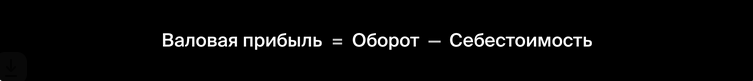

In [24]:
# чтобы окупить вложения компании в 10 млрд, в новых 200 скважинах нефти должно быть не меньше 111 тыс. бареллей
profit_threshold = (COST_PRICE / UNIT_OF_PRODUCT_PRICE) / 200
profit_threshold

111.11111111111111

In [25]:
print('Итог:')
print('------------------------------------------------------')
print(f'Средний запас предсказанного сырья в регионе 1 = {y_pred_0.mean():.4}')
print(f'Средний запас предсказанного сырья в регионе 2 = {y_pred_1.mean():.4}')
print(f'Средний запас предсказанного сырья в регионе 3 = {y_pred_2.mean():.4}')
print(f'Достаточный объем сырья для безубыточной разработки = {profit_threshold:.4}')

Итог:
------------------------------------------------------
Средний запас предсказанного сырья в регионе 1 = 92.59
Средний запас предсказанного сырья в регионе 2 = 68.73
Средний запас предсказанного сырья в регионе 3 = 94.97
Достаточный объем сырья для безубыточной разработки = 111.1


**`Промежуточный вывод`:**

Исходя из сравнения достаточного объема со средними запасами сырья прогноз неутешительный...

Близко к достаточному объему подбираются 1й и 3й регион, 2й очень далеко.

## Функция для расчёта прибыли

Для начала, соберем полезную информацию для каждого региона в отдельные датафреймы

In [26]:
# регион 1
# сopy() нужна для того, чтобы операции над valid_with_pred_0 не переходили и на X_valid_0
valid_with_pred_0 = X_valid_0.copy()

valid_with_pred_0['product'], \
valid_with_pred_0['product_pred'], \
valid_with_pred_0['id'] = y_valid_0, y_pred_0, geo_data_0['id']


# регион 2
valid_with_pred_1 = X_valid_1.copy()

valid_with_pred_1['product'], \
valid_with_pred_1['product_pred'], \
valid_with_pred_1['id'] = y_valid_1, y_pred_1, geo_data_1['id']

# регион 3
valid_with_pred_2 = X_valid_2.copy()

valid_with_pred_2['product'], \
valid_with_pred_2['product_pred'], \
valid_with_pred_2['id'] = y_valid_2, y_pred_2, geo_data_2['id']

In [27]:
# просто чтобы красиво было
valid_with_pred_0.head()

,f0,f1,f2,product,product_pred,id
71751,0.517917,-0.610097,-0.126226,10.038645,95.894952,7Z2gx
80493,0.568391,-0.086063,-0.814914,114.551489,77.572583,b2HU8
2655,0.805688,-1.613289,-1.341342,132.603635,77.892640,Y0dXD
53233,0.222503,-1.355437,-0.597275,169.072125,90.175134,Mje59
91141,-0.087941,1.433113,-0.544588,122.325180,70.510088,yqXxU


Напишем функцию `profit_checker` для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [28]:
# надо для Bootstrap
state = np.random.RandomState(12345)

In [29]:
def profit_checker(data):
    
    # отбираем 500 случайных элементов, сортируем по product_pred и отбираем 200 лучших скважин
    best_wells = data \
        .sample(500, replace=True, random_state=state) \
        .sort_values('product_pred', ascending=False) \
        .iloc[:200, :]
    
    # суммируем объемы предсказанного сырья для 200 лучших скважин и считаем оборот
    revenue = best_wells['product'].sum() * UNIT_OF_PRODUCT_PRICE
    
    # считаем валовую прибыль
    gross_profit = revenue - COST_PRICE
    
    # возвращаем валовую прибыль
    return gross_profit

Попробуем посчитать с помощью нашей функции валовую прибыль для всех трех регионов

In [30]:
print(f'Регион 1: {profit_checker(valid_with_pred_0)}')
print(f'Регион 2: {profit_checker(valid_with_pred_1)}')
print(f'Регион 3: {profit_checker(valid_with_pred_2)}')

Регион 1: 605464074.5689964
Регион 2: 334315678.3243637
Регион 3: 626175561.5691528


**`Промежуточный вывод:`**

Функция выполняет свою "функцию", данные могут отличаться каждый раз из-за сэмплирования, это дальше будет необходимо в бутстрепе.

## Расчёт прибыли и рисков для каждого региона

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [31]:
def supreme_function(data):
    
    # проведем бутстреп с 1000 выборок, найдем для этих выборок валовую прибыль и сохраним в values
    values = []
    negative_values = []
    for i in range(1000):
        revenue = profit_checker(data)
        values.append(revenue)
        
        # будем сохранять отрицательные значения валовой прибыли для подсчета рисков убытков
        if revenue < 0:
            negative_values.append(revenue)

    # Переведем в Series
    values = pd.Series(values)
    negative_values = pd.Series(negative_values)

    # сохраним 2.5% и 97.5% квантили
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    # посчитаем среднюю валовую прибыль и долю отрицательных ее значений
    mean = values.mean()
    risk_of_loss = negative_values.count() / values.count()

    # выведем все на экран
    print(f"Средняя выручка: {mean}")
    print(f"  2.5%-квантиль: {lower}")
    print(f" 97.5%-квантиль: {upper}")
    print(f"   Риск убытков: {risk_of_loss:.1%}")

In [32]:
# регион 1
supreme_function(valid_with_pred_0)

Средняя выручка: 395259148.74356645
  2.5%-квантиль: -111215545.89049526
 97.5%-квантиль: 909766941.5534226
   Риск убытков: 7.0%


In [33]:
# регион 2
supreme_function(valid_with_pred_1)

Средняя выручка: 462190324.9021858
  2.5%-квантиль: 78050810.7517417
 97.5%-квантиль: 862952060.2637234
   Риск убытков: 0.7%


In [34]:
# регион 3
supreme_function(valid_with_pred_2)

Средняя выручка: 392446381.5803054
  2.5%-квантиль: -112227625.37857565
 97.5%-квантиль: 934562914.5511636
   Риск убытков: 6.5%


**`Промежуточный вывод:`**

Видим, что если бурить 200 новых скважин в 1м или 3м регионе, то, потенциально, можно заработать больше, но! Также, выше и риск убытков 7% и 6.5% соответственно. В регионе 2, хоть и потенциал к заработку (97.5% квантиль) меньше остальных регионов, но средняя выручка наоборот больше, также риск убытков практически отсутствует (0.7%)

Предлагаю к разработке рассмотреть **регион 2**.

## Общий вывод

**`Общий вывод:`**

1. *Загрузка и подготовка данных*:
    - данные были изучены
    - был сформирован подробный EDA отчет
    - был сделан промежуточный вывод


2. *Обучение и проверка модели*:
    - было проведено разделение данных на train и valid выборки
    - проведено масштабирование численных параметров [f0, f1, f2]
    - обучили модель LogisticRegression и получили предсказания на валидационной выборке для каждого региона:
        - регион 1: средний запас предсказанного сырья = 92.6, RMSE = 37.58
        - регион 2: средний запас предсказанного сырья = 68.7, RMSE = 0.893
        - регион 3: средний запас предсказанного сырья = 94.97, RMSE = 40.03


3. *Подготовка к расчёту прибыли*:
    - был выявлен достаточный объем сырья для безубыточной разработки 200 новых скважин в регионе (~111 тыс. бареллей)


4. *Функция для расчёта прибыли*:
    - была написана функция `profit_checker` для расчета прибыли по выбранным скважинам и предсказаниям модели
    - выяснили, что регион 2 более "стабилен" и потенциально из него можно выкачать больше топлива, а прибыль будет больше, чем в других регионах


5. *Расчёт прибыли и рисков для каждого региона*:
    - применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона
    - написали для этого функцию `supreme_function`
    - выяснили, что хоть и потенциал к заработку (97.5% квантиль) у второго региона меньше остальных, но средняя выручка наоборот больше, также риск убытков практически отсутствует (0.7%)



6. **Рекомендую разработать 200 новых скважин во втором регионе**